<a href="https://colab.research.google.com/github/MohsenMaaleki/CIFAR_10_Objects_Classification/blob/main/CIFAR_10_Objects_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim


import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 

In [13]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
#trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
batch_sizes = [32, 64, 128, 256]
loss_values = {batch_size: [] for batch_size in batch_sizes}  # Store the loss values for each batch size


for batch_size in batch_sizes:
    # Create a dataloader with the desired batch size
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Train the model on the CIFAR-10 dataset for 30 epochs
    for epoch in range(2):  # Loop through 10 epochs

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):  # Loop through the data in the training set
            inputs, labels = data  # Get the inputs and labels from the data

            optimizer.zero_grad()  # Zero the gradient buffers

            outputs = model(inputs)  # Get the model outputs
            loss = criterion(outputs, labels)  # Calculate the loss
            loss.backward()  # Perform backpropagation
            optimizer.step()  # Update the parameters of the model

            running_loss += loss.item()  # Add up the loss for each iteration

        avg_loss = running_loss / len(trainloader)  # Calculate the average loss for each epoch
        loss_values[batch_size].append(avg_loss)  # Store the average loss value for this epoch and batch size
        print('[Batch size: %d, Epoch %d] loss: %.3f' % (batch_size, epoch + 1, avg_loss))  # Print the average loss for each epoch


[Batch size: 32, Epoch 1] loss: 1.850
[Batch size: 32, Epoch 2] loss: 1.756
[Batch size: 64, Epoch 1] loss: 1.695
[Batch size: 64, Epoch 2] loss: 1.686
[Batch size: 128, Epoch 1] loss: 1.664
[Batch size: 128, Epoch 2] loss: 1.653
[Batch size: 256, Epoch 1] loss: 1.643
[Batch size: 256, Epoch 2] loss: 1.645


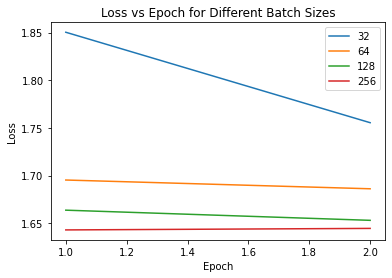

In [ ]:
# Plot the loss values for each batch size and epoch
for batch_size, values in loss_values.items():
    plt.plot(range(1, 3), values, label=str(batch_size))
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch for Different Batch Sizes')
plt.legend()
plt.show()

In [ ]:
accuracies = []
for batch_size in batch_sizes:
    # Evaluate the model on the CIFAR-10 test set for a specific batch size
    correct = 0  # Keep track of the number of correctly classified samples
    total = 0  # Keep track of the total number of samples evaluated
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
    with torch.no_grad():  # Don't keep track of gradients during evaluation
        for data in testloader:
            images, labels = data
            outputs = model(images)  # Get the model outputs for a batch of test data
            _, predicted = torch.max(outputs.data, 1)  # Get the class with the highest predicted probability
            total += labels.size(0)  # Increment the number of samples evaluated
            correct += (predicted == labels).sum().item()  # Increment the number of correctly classified samples

    accuracy = 100 * correct / total  # Calculate the accuracy
    print('[Batch size: %d] Accuracy of the network on the 10000 test images: %.2f %%' % (batch_size, accuracy))  # Print the accuracy for the current batch size
    accuracies.append(accuracy)


[Batch size: 32] Accuracy of the network on the 10000 test images: 40.23 %
[Batch size: 64] Accuracy of the network on the 10000 test images: 42.47 %
[Batch size: 128] Accuracy of the network on the 10000 test images: 42.69 %
[Batch size: 256] Accuracy of the network on the 10000 test images: 42.32 %


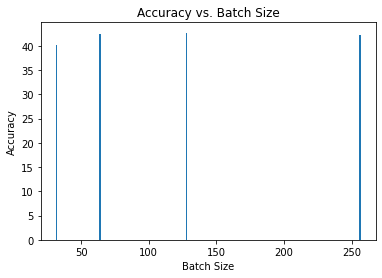

In [ ]:
plt.bar(batch_sizes, accuracies)
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Batch Size')
plt.show()

#Different Hyperparameters :
  1-Learning rate: 0.01, Batch size: 64, Optimizer: SGD, Epochs: 10, Activation function: ReLU

In [15]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.SGD(model.parameters(), lr=0.01)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)


# Train the model
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/2], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in testloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 1.9142
Epoch [2/2], Loss: 1.7332
Finished Training
Accuracy of the network on the test set: 39.62%


# Different Hyperparameters : 
2-Learning rate: 0.1, Batch size: 128, Optimizer: Adam, Epochs: 20, Activation function: Tanh

In [16]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.Tanh(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adam(model.parameters(), lr=0.1)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# Train the model
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/2], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in testloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 20.6200
Epoch [2/2], Loss: 13.6148
Finished Training
Accuracy of the network on the test set: 19.50%


#Different Hyperparameters:
3-Learning rate: 0.001, Batch size: 256, Optimizer: Adagrad, Epochs: 30, Activation function: Sigmoid

In [17]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.Sigmoid(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adagrad(model.parameters(), lr=0.001)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=256, shuffle=False, num_workers=2)


# Train the model
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/2], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in testloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))


Epoch [1/2], Loss: 2.0138
Epoch [2/2], Loss: 1.8549
Finished Training
Accuracy of the network on the test set: 36.68%


#Different Hyperparameters : 
4-Learning rate: 0.05, Batch size: 512, Optimizer: RProp, Epochs: 40, Activation function: Leaky ReLU


In [18]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Rprop(model.parameters(), lr=0.05)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=512, shuffle=False, num_workers=2)


# Train the model
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/2], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in testloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 270.9387
Epoch [2/2], Loss: 75.5700
Finished Training
Accuracy of the network on the test set: 27.68%


#Different Hyperparameteers:
5-Learning rate: 0.005, Batch size: 128, Optimizer: Adamax, Epochs: 50, Activation function: ELU

In [19]:
# Load the pre-trained ResNet18 model
model = torchvision.models.resnet18(pretrained=True)

# Freeze all layers in the feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace the last layer with a fully connected layer for 10 classes
model.fc = torch.nn.Sequential(
    torch.nn.Linear(512, 512),
    torch.nn.ELU(),
    torch.nn.Linear(512, 10)
)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Set the optimizer to SGD with a learning rate of 0.01
optimizer = optim.Adamax(model.parameters(), lr=0.05)


# Load the CIFAR-10 dataset and perform data augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training set
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader for the training set
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

# Load the test set
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Create a DataLoader for the test set
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# Train the model
for epoch in range(2):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('Epoch [{}/2], Loss: {:.4f}'.format(epoch + 1, running_loss / len(trainloader)))

print('Finished Training')


# Evaluate the model on the test set
with torch.no_grad():
    correct = 0
    total = 0
    for data, target in testloader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

    accuracy = 100 * correct / total
    print('Accuracy of the network on the test set: {:.2f}%'.format(accuracy))


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/2], Loss: 3.8214
Epoch [2/2], Loss: 1.8854
Finished Training
Accuracy of the network on the test set: 33.52%
